In [1]:
%matplotlib notebook
import tessreduce as tr
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.coordinates import SkyCoord
from astropy import units as u

# HV 6327

In [2]:
ra = 5.079625
dec = -73.8689167

In [3]:
c = SkyCoord(ra=float(ra)*u.degree, dec=float(dec) *u.degree, frame='icrs')
tess = lk.search_tesscut(c,sector=13)
tpf = tess.download(cutout_size=50)
aper_b18 = np.zeros(tpf.shape[1:], dtype=bool)
#aper_b18[44:48, 44:47] = True
res = tr.Quick_reduce(tpf,calibrate=False)#,aper=aper_b18)

made reference
made source mask
calculating background
background subtracted
calculating centroids
images shifted
made light curve


clustering
[False False False False  True False False False False False False  True
  True False False]
[[ True  True  True ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


<IPython.core.display.Javascript object>


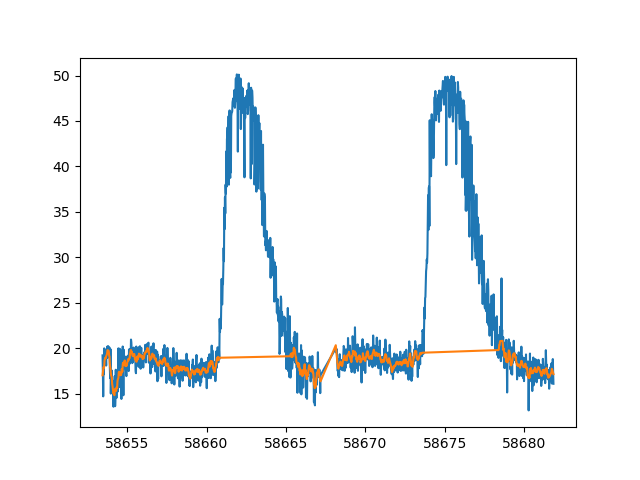

<IPython.core.display.Javascript object>


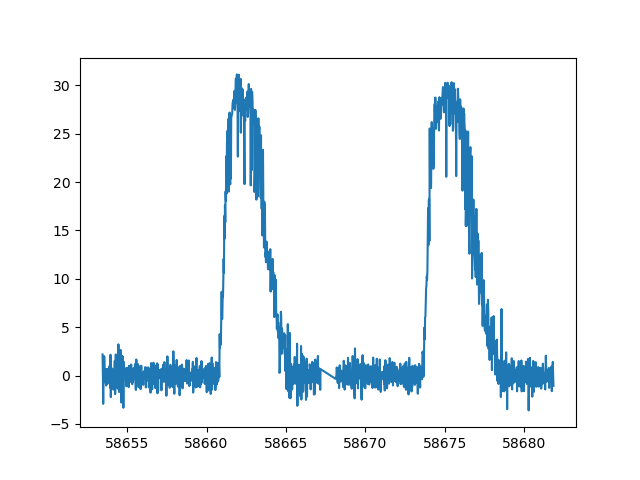

In [7]:
lc = res['lc']
test = tr.Remove_stellar_variability(lc,)
plt.figure()
plt.plot(lc[0],lc[1])
plt.plot(lc[0],test)

plt.figure()
plt.plot(lc[0],lc[1]-test)

In [64]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(3, affinity='precomputed', n_init=100,
                        assign_labels='discretize')

In [65]:
lc

array([[5.86534510e+04, 5.86534719e+04, 5.86534927e+04, ...,
        5.86818055e+04, 5.86818264e+04, 5.86818472e+04],
       [1.92120972e+01, 1.73708745e+01, 1.47003992e+01, ...,
        1.88051548e+01, 1.74127233e+01, 1.60860247e+01]])

In [79]:
clustering = SpectralClustering().fit(lc.T)

In [80]:
lab = clustering.labels_

In [82]:
lab

array([0, 0, 0, ..., 7, 7, 7], dtype=int32)

<IPython.core.display.Javascript object>


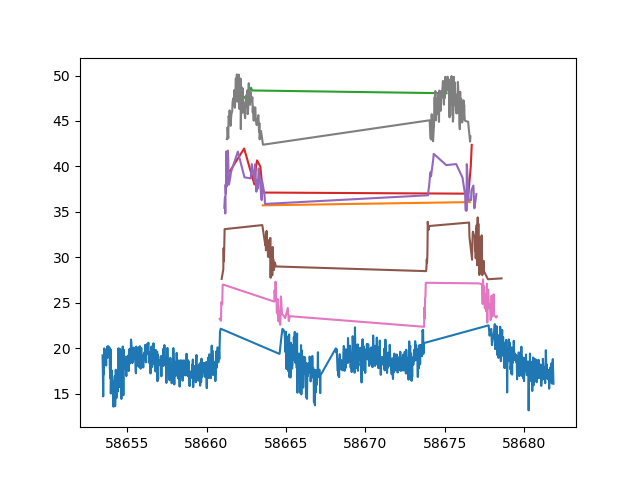

In [98]:
plt.figure()
for i in range(max(lab)+1):
    plt.plot(lc[0,lab==i],lc[1,lab==i])

<IPython.core.display.Javascript object>


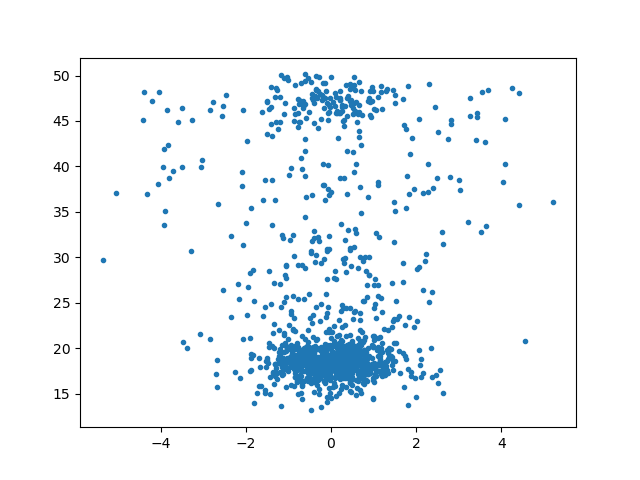

In [86]:
plt.figure()
plt.plot(np.gradient(lc[1]),lc[1],'.')

In [205]:
arr = np.array([np.gradient(lc[1]),lc[1]])

In [118]:
clustering = SpectralClustering(n_clusters=2).fit(arr.T)
lab = clustering.labels_

In [119]:
max(lab)

1

<IPython.core.display.Javascript object>


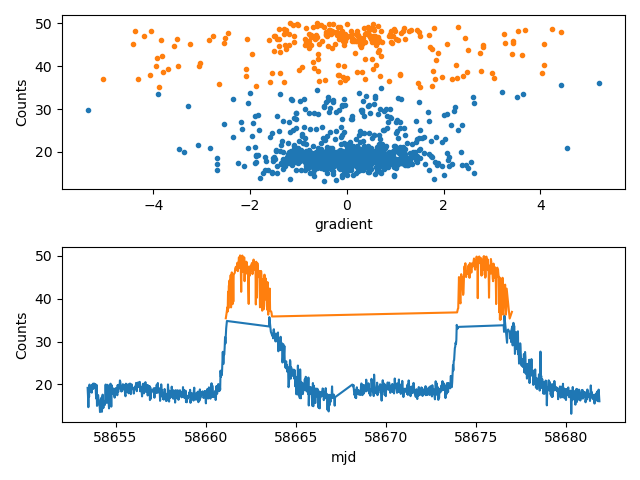

In [120]:
plt.figure()
plt.subplot(211)
for i in range(max(lab)+1):
    plt.plot(np.gradient(lc[1])[lab==i],lc[1,lab==i],'.')
plt.ylabel('Counts')
plt.xlabel('gradient')

plt.subplot(212)
for i in range(max(lab)+1):
    plt.plot(lc[0,lab==i],lc[1,lab==i])
plt.ylabel('Counts')
plt.xlabel('mjd')
plt.tight_layout()

In [5]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

In [335]:
arr.shape

(2, 1262)

In [6]:
def Cluster_lc(lc):
    arr = np.array([np.gradient(lc[1]),lc[1]])
    clust = OPTICS(min_samples=6, xi=.05, min_cluster_size=.05)
    opt = clust.fit(arr.T)
    lab = opt.labels_
    keys = np.unique(opt.labels_)
    
    m = np.zeros(len(keys))
    for i in range(len(keys)):
        m[i] = np.nanmedian(lc[1,keys[i]==lab])
    bkg_ind = lab == keys[np.nanargmin(m)]
    other_ind = ~bkg_ind
    
    return bkg_ind, other_ind

In [344]:
bkg_ind, other_ind = Cluster_lc(lc)

In [ ]:
np.unique()

In [523]:
len(keys)

5

In [7]:
from scipy.ndimage.filters import convolve
def Identify_masks(Obj):
    """
    Uses an iterrative process to find spacially seperated masks in the object mask.
    """
    objsub = np.copy(Obj*1)
    Objmasks = []

    mask1 = np.zeros((Obj.shape))
    if np.nansum(objsub) > 0:
        mask1[np.where(objsub==1)[0][0]] = 1
        
        while np.nansum(objsub) > 0:
                
            conv = ((convolve(mask1*1,np.ones(3),mode='constant', cval=0.0)) > 0)*1.0
            objsub = objsub - mask1
            objsub[objsub < 0] = 0
            if np.nansum(conv*objsub) > 0:

                mask1 = mask1 + (conv * objsub)
                mask1 = (mask1 > 0)*1
            else:

                Objmasks.append(mask1 > 0)
                mask1 = np.zeros((Obj.shape))
                if np.nansum(objsub) > 0:
                    mask1[np.where(objsub==1)[0][0]] = 1
    return np.array(Objmasks)

In [382]:
other_ind.shape

(1262,)

In [373]:
np.where(other_ind==1)[0]

array([  5, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
       153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178,
       179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
       192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204,
       205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217,
       218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,
       231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243,
       244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256,
       257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269,
       270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 283,
       284, 285, 286, 287, 288, 289, 290, 292, 293, 294, 295, 296, 297,
       298, 299, 300, 301, 303, 304, 305, 306, 307, 308, 309, 310, 311,
       312, 313, 314, 315, 316, 317, 319, 321, 325, 330, 334, 33

In [384]:
test = Identify_masks(other_ind)

In [386]:
test.shape

(18, 1262)

<IPython.core.display.Javascript object>


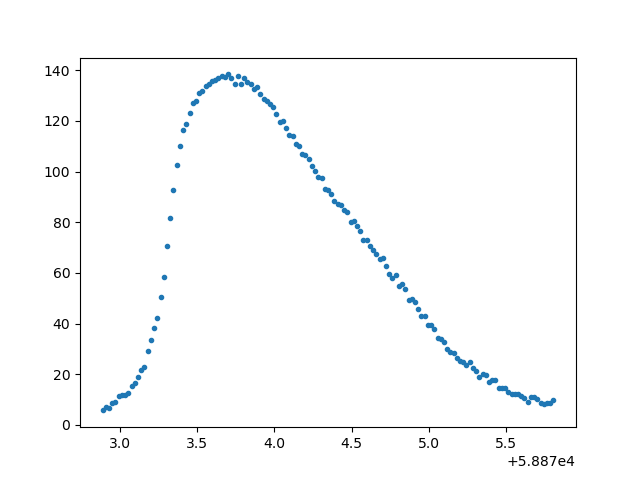

In [381]:
plt.figure()
plt.plot(lc[0,test[1]>0],lc[1,test[1]>0],'.')

In [ ]:
def Continuous_truth(arr):
    res = []
    while 

In [388]:
np.nansum([True,True])

2

In [8]:
from astropy.stats import sigma_clip
def Cluster_cut(lc,err=None,sig=5,smoothing=True):
    bkg_ind, other_ind = Cluster_lc(lc)
    leng = 5
    if smoothing:
        for i in range(leng-2):
            kern = np.zeros((leng))
            kern[[0, -1]] = 1
            other_ind[convolve(other_ind*1, kern) > 1] = True
            leng -= 1
    segments = Identify_masks(other_ind)
    clipped = lc[1].copy()
    med = np.nanmedian(clipped[bkg_ind])
    std = np.nanstd(clipped[bkg_ind])
    if err is not None:
        mask = (clipped-1*err > med + sig*std)
    else:
        mask = (clipped > med + sig*std)
    overlap = np.nansum(mask * segments,axis=1) > 0
    mask = np.nansum(segments[overlap],axis=0)>0 
    return mask
        

In [9]:
bkg_ind, other_ind = Cluster_lc(lc)

<IPython.core.display.Javascript object>


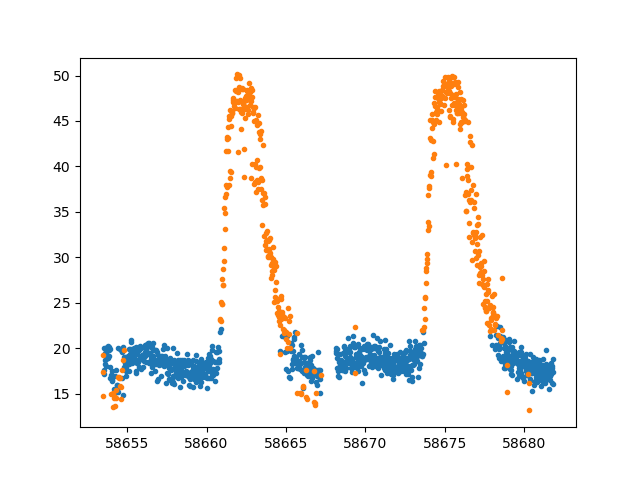

In [10]:
plt.figure()
plt.plot(lc[0,bkg_ind],lc[1,bkg_ind],'.')
plt.plot(lc[0,other_ind],lc[1,other_ind],'.')
    

In [520]:
arr = np.array([np.gradient(lc[1]),lc[1]])
clust = OPTICS(min_samples=6, xi=.05, min_cluster_size=.05)
opt = clust.fit(arr.T)
lab = opt.labels_
keys = np.unique(opt.labels_)

<IPython.core.display.Javascript object>


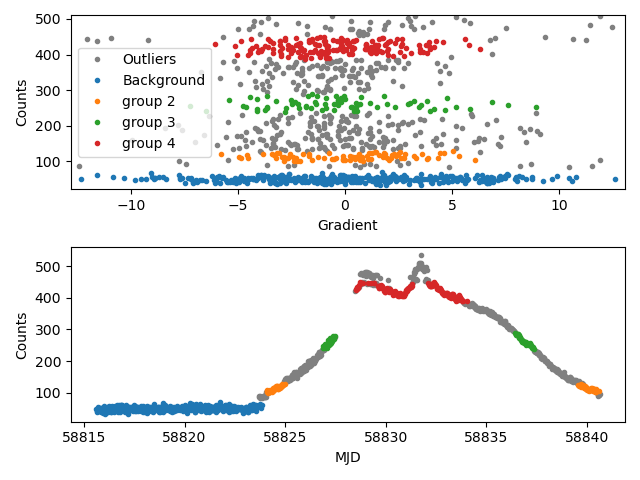

In [521]:
colours = ['grey','C0','C1','C2','C3','C4']
labels = ['Outliers','Background','group 2','group 3','group 4']
plt.figure()
plt.subplot(211)
for i in range(len(keys)):
    plt.plot(np.gradient(lc[1])[lab==keys[i]],lc[1,lab==keys[i]],'.',color=colours[i],label=labels[i])
plt.ylabel('Counts')
plt.xlabel('Gradient')
plt.legend()  

plt.subplot(212)
for i in range(len(keys)):
    plt.plot(lc[0,lab==keys[i]],lc[1,lab==keys[i]],'.',color=colours[i])
plt.ylabel('Counts')
plt.xlabel('MJD')
plt.tight_layout()

In [483]:
def Event_isolation(lc,err=None,length=5):
    mask = Cluster_cut(lc,err)
    outliers = Identify_masks(mask)
    good = np.nansum(outliers,axis=1) > length
    outliers = outliers[good]
    lcs = outliers * lc[1][np.newaxis,:]
    lcs[lcs == 0] = np.nan
    return lcs

In [518]:
events = Event_isolation(lc,length=5)

<IPython.core.display.Javascript object>


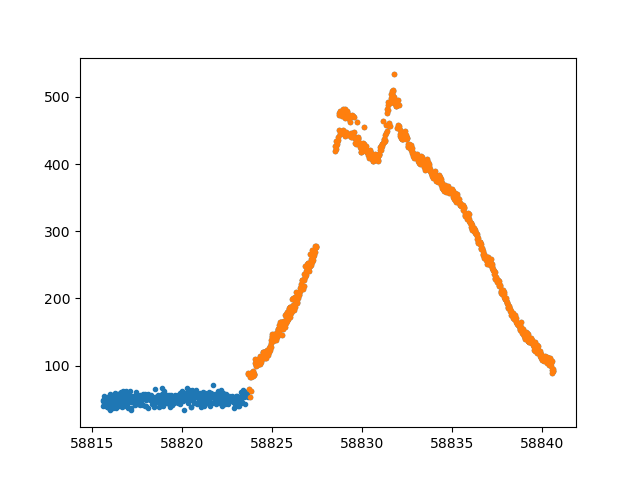

In [519]:
plt.figure()
plt.plot(lc[0],lc[1],'.')
for e in events:
    plt.plot(lc[0],e,'.')
    

In [446]:
mask = Cluster_cut(lc,test2)

<IPython.core.display.Javascript object>


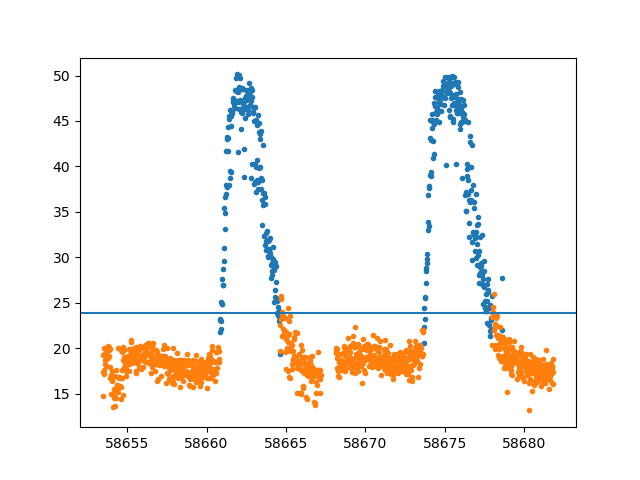

In [447]:
plt.figure()
plt.plot(lc[0,mask],lc[1,mask],'.')
plt.plot(lc[0,~mask],lc[1,~mask],'.')
plt.axhline(med + 5*std)

In [406]:
clipped

array([2.32891663, 3.26892956, 3.51594302, ..., 3.53113255, 2.93997568,
       2.87112551])

In [396]:
segments.shape

(18, 1262)

In [397]:
lc.shape

(2, 1262)

In [392]:
Cluster_cut(lc)

ValueError: operands could not be broadcast together with shapes (7219,7) (18,1262) 

In [ ]:
def sig_err(data,mask=None,err=None,sig=3,maxiter=10):
    if mask is None:
        mask = np.ones(data) > 0
        
    if sig is None:
        sig = 3
    clipped = data.copy()
    ind = np.arange(0,len(data))
    breaker = 0
    if err is not None:
        for i in range(maxiter):
            nonan = np.isfinite(clipped)
            med = np.average(clipped[nonan],weights=1/err[nonan])
            #med = np.nanmedian(clipped)
            std = np.nanstd(clipped)
            mask = (clipped-1*err > med + 3*std) #| (clipped+1*err < med - 3*std)
            clipped[mask] = np.nan
            if ~mask.any():
                break

        mask = np.isnan(clipped)
    else:
        mask = sigma_clip(data).mask
    return mask

In [427]:
lc = res['lc']

arr = np.array([np.gradient(lc[1]),lc[1]])
opt = clust.fit(arr.T)

lab = opt.labels_

In [428]:
keys = np.unique(opt.labels_)

In [429]:
keys

array([-1,  0,  1])

<IPython.core.display.Javascript object>


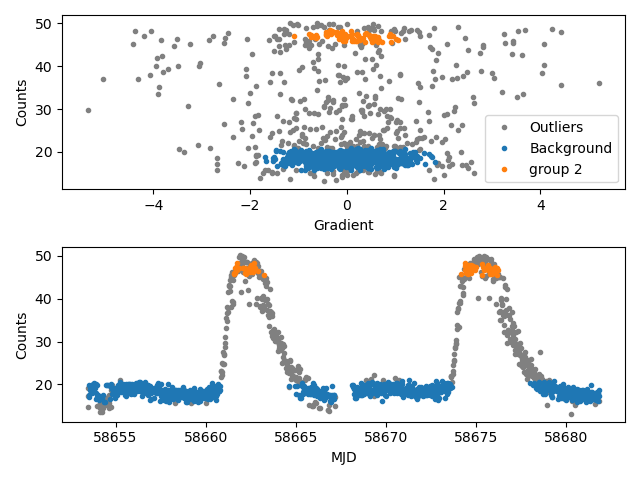

In [430]:
colours = ['grey','C0','C1','C2','C3','C4']
labels = ['Outliers','Background','group 2','group 3','group 4']
plt.figure()
plt.subplot(211)
for i in range(len(keys)):
    plt.plot(np.gradient(lc[1])[lab==keys[i]],lc[1,lab==keys[i]],'.',color=colours[i],label=labels[i])
plt.ylabel('Counts')
plt.xlabel('Gradient')
plt.legend()  

plt.subplot(212)
for i in range(len(keys)):
    plt.plot(lc[0,lab==keys[i]],lc[1,lab==keys[i]],'.',color=colours[i])
plt.ylabel('Counts')
plt.xlabel('MJD')
plt.tight_layout()

#plt.savefig('svs1755_clean_example.pdf')

In [320]:
m = np.zeros(len(keys))
for i in range(len(keys)):
    m[i] = np.nanmedian(lc[1,keys[i]==lab])
bkg_ind = keys[np.nanargmin(m)]
peak_inds = keys[np.nanargmax(m)]

Can I also use the groups to find the optimal tail length?

In [321]:
scatter = (lab == -1) 
peaks = (lab == peak_inds)
back = (lab == bkg_ind)

In [322]:
back

array([ True,  True,  True, ...,  True,  True,  True])

In [323]:
med = np.nanmedian(lc[1,back])
std = np.nanstd(lc[1,back])

In [325]:
med

3.3418573150725477

In [431]:
flux = res['flux']
mask = tr.Source_mask(flux)
test2 = np.nanmean(flux*mask,axis=(1,2))

<IPython.core.display.Javascript object>


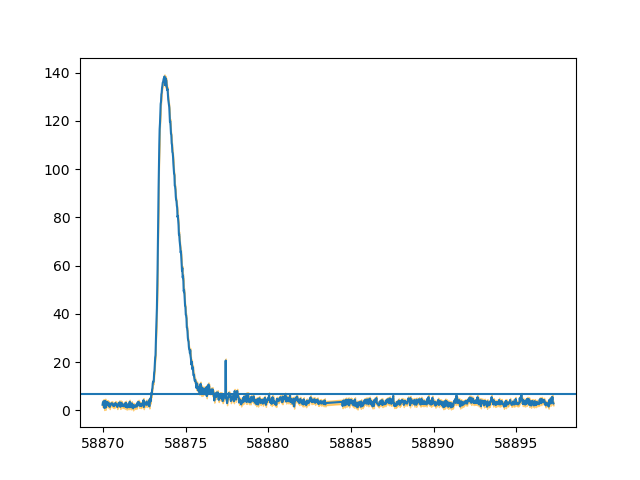

In [327]:
plt.figure()
plt.plot(lc[0],lc[1])
plt.fill_between(lc[0],lc[1]-test2,lc[1]+test2,color='orange',alpha=.5)
plt.axhline(med+3*std)


<IPython.core.display.Javascript object>


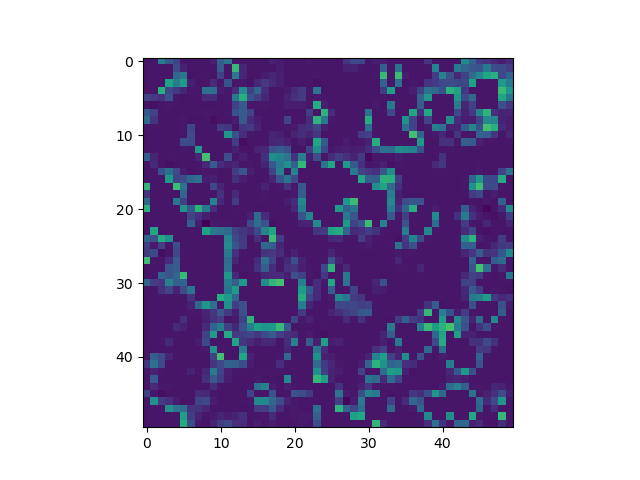

In [314]:
plt.figure()
plt.imshow(mask[100]*flux[100],vmax=10)

In [236]:
mask.shape

(1308, 50, 50)

In [251]:
flux = res['flux']
mask = tr.Source_mask(flux)
test2 = np.nanmean(flux*mask,axis=(1,2))

In [249]:
test

array([0.01417882, 0.01341751, 0.01404019, ..., 0.05451345, 0.05615888,
       0.05125276])

<IPython.core.display.Javascript object>


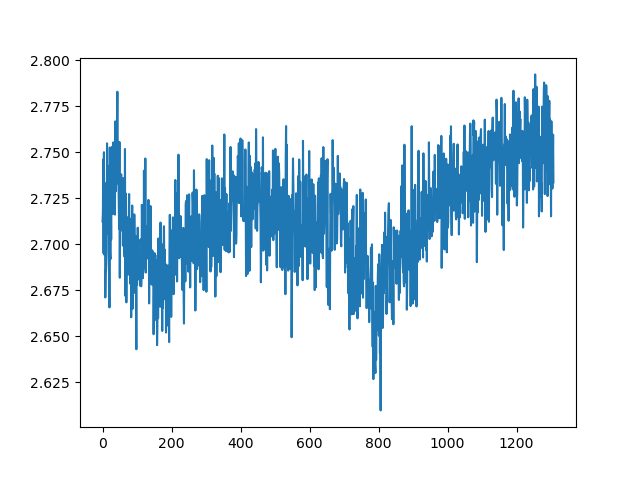

In [253]:
plt.figure()
#plt.plot(test)
plt.plot(test2)

<IPython.core.display.Javascript object>


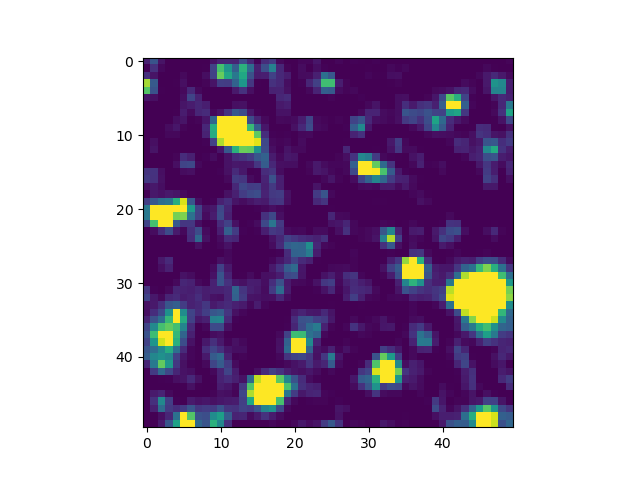

In [17]:
plt.figure()
plt.imshow(res['flux'][100],vmax=100)

In [18]:
import pandas as pd

In [30]:
data = pd.read_csv('../lcs/HV_11902.csv')

<IPython.core.display.Javascript object>


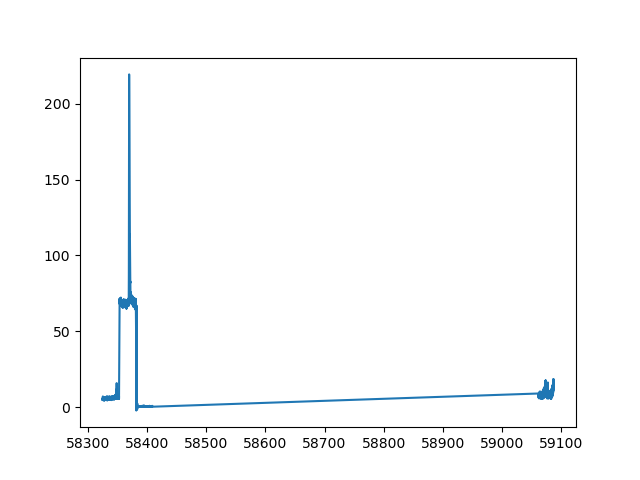

<IPython.core.display.Javascript object>


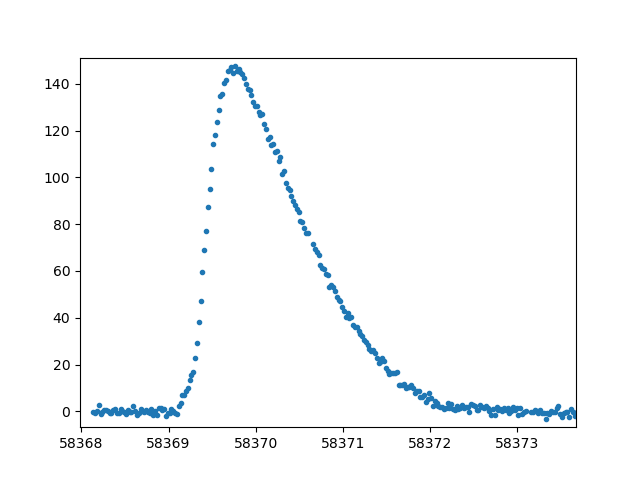

In [35]:
plt.figure()
plt.plot(data['mjd'],data['flux'],'-')
plt.figure()
plt.plot(data['mjd'],data['flux']-data['trend2'],'.')

In [8]:
c = SkyCoord('00:42:40.640 +41:07:45.80', unit=(u.hourangle, u.deg), frame='icrs')
c = SkyCoord('03 32 15.48 +58 47 22.5', unit=(u.hourangle, u.deg), frame='icrs')
#SVS 1755 Good example for clustering 
#c = SkyCoord('10 18 13.12 +71 55 44.2', unit=(u.hourangle, u.deg), frame='icrs')

#c = SkyCoord('00:43:01.545 +41:17:59.62', unit=(u.hourangle, u.deg), frame='icrs')

#c = SkyCoord('09 55 58.46	-68 09 41.3', unit=(u.hourangle, u.deg), frame='icrs')
c = SkyCoord('01 10 13.12	+60 04 35.7', unit=(u.hourangle, u.deg), frame='icrs')

tess = lk.search_tesscut(c,sector=18)

In [514]:
tess

#,observation,target_name,productFilename,distance
0,TESS Sector 19,"53.064499999999995, 58.78958333333333",TESSCut,0.0


In [9]:
tpf = tess.download(cutout_size=50)
#aper_b18 = np.zeros(tpf.shape[1:], dtype=bool)
#aper_b18[44:48, 44:47] = True
res = tr.Quick_reduce(tpf,calibrate=False)#,aper=aper_b18)

made reference
made source mask
calculating background
background subtracted
calculating centroids
images shifted
made light curve


In [10]:
lc = res['lc']

<IPython.core.display.Javascript object>


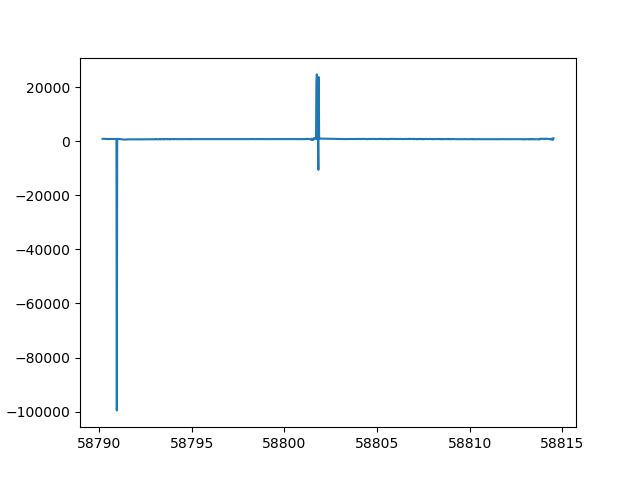

In [11]:

plt.figure()
plt.plot(res['lc'][0],res['lc'][1])

In [ ]:
test

<IPython.core.display.Javascript object>


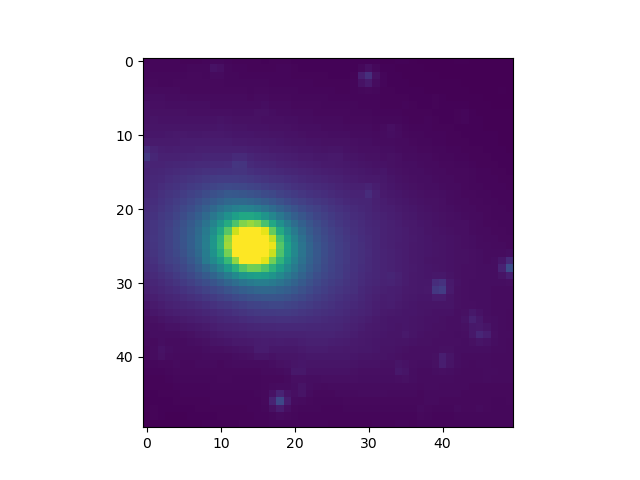

In [334]:
plt.figure()
plt.imshow(tpf.flux[100],vmax=20000)